## The method of stock prediction with various analize method (For practice)
- This is my python project for improving my skill
- For stock prediction, the proposed method uses various algorithms such as statistical analysis, probability model and neural networks
- The simple s&p500 data is used


## 다양한 분석 기법을 활용한 주가 예측 방법 (연습) 
- 파이썬을 활용하여 다양한 분석 기법을 활용한 주가 예측 방법 구현 수행 (습작용)
- 그냥 널리 알려져 있는 통계적 분석, 확률모델, 인공 신경망 등등 여러 방법 활용
- 데이터 역시 단순한 종가 등 수학적 정보만 활용 
- 어떤 분석 방법이 예측력이 좋은지, 어떻게 하면 예측력을 높일 수 있는지 등


## 고려사항 
- y 값의 변화 
    - 기본적으로 학습을 위해 활용하는 y의 값이 지수값을 사용하는 경우, 성능이 떨어진다(경험상) 
    - y값을 결과적으로 up/down 등 라벨을 예측하는 쪽의 더 현실성 있다
    - 다양한 형태의 y 값의 변화 및 성능비교 수행 
- 지수 값 활용시 수익률로 변화 
    - 시간이 지나면서 규모 자체가 바뀔 수 있음 (10년전의 짜장면 값과 지금 짜장면 값의 차이 존재) 
    - 전 시간 영역에서 학습을 하는 것이기 때문에 스케일 조절 필요
        - 수익률 (미래 - 현재)/현재 , (현재 - 과거)/과거 
- 지금 데이터에서는 각 회사들의 지수임 
    - 각 회사별로 계산하기 
    - 있는 데이터 기반 종합지수 구하기 


---
## 시도해볼것들 
### 토픽 모델링 
### 인공 신경망 
### 평가 방법 
### 비교 평가 
--- 
## Reference 
[회귀분석]
- http://3months.tistory.com/137 
    - 파이썬으로 선형 회귀 분석
- http://uncoded.tistory.com/21 
    - 파이썬으로 로지스틱 회귀 분석 구현 
- https://towardsdatascience.com/logistic-regression-using-python-sklearn-numpy-mnist-handwriting-recognition-matplotlib-a6b31e2b166a
    - 파이썬 heatmap 코드(confusion matrix 시각화) 

  
[LSTM-tensorflow]
- http://www.hanbit.co.kr/media/channel/view.html?cms_code=CMS6074576268
    - tensorflow를 기반으로 LSTM 적용 예제 = 근데 주식 단어 기반 
- http://coolingoff.tistory.com/54 
    - multiRNNCell 구조를 확인하기 좋은 듯 
- https://github.com/LA-JAMES/-Encoder-Decoder-Simple-Deep-LSTM-for-Tensorflow/blob/master/lstm_seq_to_seq.py
    - LSTM 기반 encoder/decoder 구조 
- https://lilianweng.github.io/lil-log/2017/07/08/predict-stock-prices-using-RNN-part-1.html 
    - LSTM 주식 시장에서 구현한 것 

---
    

In [247]:
''' 
Library  
'''
# default 
import numpy as np 
import pandas as pd
from pprint import pprint

# For regression   
from sklearn import linear_model, metrics
from sklearn.cross_validation import train_test_split

import matplotlib.pyplot as plt 
import seaborn as sns



## 1) Data read and describe part 
- using pandas, read csv file 
---
- pandas 라이브러리를 활용하여 stock data(csv)를 읽어오자 
- 데이터에 대한 성격을 보자 
- 데이터 분리 622 / 82 


In [9]:
'''
date = 날짜 
open = 시가? - 시작 시 가격  
high = 고가 - 당일 최고가격 
low = 저가 - 당일 최저가격 
close = 종가 - 장 마감 가격 
volume = 거래량 
Name = sp500 회사이름 - 약어 
'''
temp_sp500_data = pd.read_csv('all_stocks_5yr.csv', header= 0, names=['date','open','high','low','close','volume','Name'])
temp_sp500_data.describe()

,open,high,low,close,volume
count,619029.000000,619032.000000,619032.000000,619040.000000,6.190400e+05
mean,83.023334,83.778311,82.256096,83.043763,4.321823e+06
std,97.378769,98.207519,96.507421,97.389748,8.693610e+06
min,1.620000,1.690000,1.500000,1.590000,0.000000e+00
25%,40.220000,40.620000,39.830000,40.245000,1.070320e+06
50%,62.590000,63.150000,62.020000,62.620000,2.082094e+06
75%,94.370000,95.180000,93.540000,94.410000,4.284509e+06
max,2044.000000,2067.990000,2035.110000,2049.000000,6.182376e+08


### 종합 지수 구하기 
- 현재 데이터는 505 개의 기업들의 정보이고, 일단 각 기업별로 주가 예측하는 것이 아니라 시장의 상황을 예측한은 것이 목표이기 때문에 종합 지수를 구한다 
- 종합 지수의 계산식은 다음과 같다 
  
$$ 비교시점의\;시가총액/기준시점의\;시가총액 *100 = 종합주가지수$$
  
  
- 시가총액은 $종가 * Volume$으로 구하자 
- 2013년 2월 8일의 S&P500 지수가 1517.93 임
    - 계산해보니 59939632.241430454 정도가 기준 시가 총액인듯  
- 날짜별로 시가 총액 계산, 기준 시점을 1961 정도로 가정하자  


In [10]:
temp_sp500_data['close_vol'] = temp_sp500_data['close'] * temp_sp500_data['volume']
temp_sp500_data['high_vol'] = temp_sp500_data['high'] * temp_sp500_data['volume']
temp_sp500_data['low_vol'] = temp_sp500_data['low'] * temp_sp500_data['volume']
temp_sp500_data['open_vol'] = temp_sp500_data['open'] * temp_sp500_data['volume']
temp_sp500_data = temp_sp500_data.groupby(['date'])[['open_vol','high_vol','low_vol','close_vol']].sum()

In [11]:
temp_sp500_data['close_vol'][0]/59939632.241430454

1517.93

In [12]:
temp_sp500_data['close_vol'] /= 59939632.241430454
temp_sp500_data['high_vol'] /= 59939632.241430454
temp_sp500_data['low_vol'] /= 59939632.241430454
temp_sp500_data['open_vol'] /= 59939632.241430454

In [13]:
sp500_data = temp_sp500_data
sp500_data = pd.concat([sp500_data, sp500_data['close_vol'].shift(1).rename('lag1'), 
                        sp500_data['close_vol'].shift(2).rename('lag2'), 
                        sp500_data['close_vol'].shift(3).rename('lag3'),
                        sp500_data['close_vol'].shift(4).rename('lag4'), 
                        sp500_data['close_vol'].shift(5).rename('lag5'),
                        sp500_data['close_vol'].shift(6).rename('lag6'), 
                        sp500_data['close_vol'].shift(7).rename('lag7'), 
                        sp500_data['close_vol'].shift(-1).rename('fu1'),
                       sp500_data['close_vol'].shift(-7).rename('fu7'),
                       sp500_data['close_vol'].shift(-30).rename('fu30')], 
                        axis=1).dropna()

In [14]:
sp500_data['lag1'] = (sp500_data['close_vol']-sp500_data['lag1'])/sp500_data['lag1']
sp500_data['lag2'] = (sp500_data['close_vol']-sp500_data['lag2'])/sp500_data['lag2']
sp500_data['lag3'] = (sp500_data['close_vol']-sp500_data['lag3'])/sp500_data['lag3']
sp500_data['lag4'] = (sp500_data['close_vol']-sp500_data['lag4'])/sp500_data['lag4']
sp500_data['lag5'] = (sp500_data['close_vol']-sp500_data['lag5'])/sp500_data['lag5']
sp500_data['lag6'] = (sp500_data['close_vol']-sp500_data['lag6'])/sp500_data['lag6']
sp500_data['lag7'] = (sp500_data['close_vol']-sp500_data['lag7'])/sp500_data['lag7']
sp500_data['fu1'] = (sp500_data['fu1']-sp500_data['close_vol'])/sp500_data['close_vol']
sp500_data['fu7'] = (sp500_data['fu7']-sp500_data['close_vol'])/sp500_data['close_vol']
sp500_data['fu30'] = (sp500_data['fu30']-sp500_data['close_vol'])/sp500_data['close_vol']

In [15]:
# data 확인 
sp500_data[:2]


,open_vol,high_vol,low_vol,close_vol,lag1,lag2,lag3,lag4,lag5,lag6,lag7,fu1,fu7,fu30
date,,,,,,,,,,,,,,
2013-02-20,1815.199737,1824.402830,1780.073715,1785.461146,0.046659,-0.053178,0.034148,0.133162,0.120397,0.340904,0.176247,0.039050,-0.072469,-0.128791
2013-02-21,1865.211596,1878.768122,1836.587860,1855.182716,0.039050,0.087531,-0.016205,0.074532,0.177412,0.164148,0.393266,-0.204079,-0.177415,-0.097639


In [16]:
#split data 
print(len(sp500_data))
_622_data = sp500_data[0:int(len(sp500_data)*0.6)]
_622_data_eval = sp500_data[int(len(sp500_data)*0.6)+1:int(len(sp500_data)*0.8)]
_622_data_test = sp500_data[int(len(sp500_data)*0.8)+1:-1]

_82_data = sp500_data[0:int(len(sp500_data)*0.8)]
_82_data_eval = sp500_data[int(len(sp500_data)*0.8)+1:-1]




1222


In [17]:
_622_data[:3]

,open_vol,high_vol,low_vol,close_vol,lag1,lag2,lag3,lag4,lag5,lag6,lag7,fu1,fu7,fu30
date,,,,,,,,,,,,,,
2013-02-20,1815.199737,1824.402830,1780.073715,1785.461146,0.046659,-0.053178,0.034148,0.133162,0.120397,0.340904,0.176247,0.039050,-0.072469,-0.128791
2013-02-21,1865.211596,1878.768122,1836.587860,1855.182716,0.039050,0.087531,-0.016205,0.074532,0.177412,0.164148,0.393266,-0.204079,-0.177415,-0.097639
2013-02-22,1470.934486,1484.539169,1457.896628,1476.579784,-0.204079,-0.172998,-0.134411,-0.216977,-0.144757,-0.062873,-0.073429,0.208394,0.155377,-0.107569



## 2) 회귀모델 적용(regression model) 
- 선형 회귀 모델을 이용한 지수 예측 
- 로지스틱 회귀 모델을 이용한 up/down 예측 
- 기타 

### [1] 단순 선형 회귀 모형 
- 단순 선형 회귀 모델로 Y(결과)에 대한 X(정보)를 fitting한다 식은 아래와 같다
- 결과물은 model.coef (정보에 대한 가중치)와 model.intercept(절편)에 저장된다

$$ Y \sim  + W_{1}*lag1+...+ W_{7}*lag7 + intercept $$ 



In [18]:
#basic linear regression 
model = linear_model.LinearRegression()
x_vars1 = ['lag1','lag2','lag3','lag4','lag5','lag6','lag7']
model_1_1 = model.fit(_622_data[x_vars1], _622_data["fu1"]) # model.fit(x,y)
model = linear_model.LinearRegression()
model_1_7 = model.fit(_622_data[x_vars1], _622_data["fu7"]) # model.fit(x,y)
model = linear_model.LinearRegression()
model_1_30 = model.fit(_622_data[x_vars1], _622_data["fu30"]) # model.fit(x,y)
print("가중치 = ", model_1_1.coef_, "\n절편 =", model_1_1.intercept_)
print("가중치 = ", model_1_7.coef_, "\n절편 =", model_1_7.intercept_)
print("가중치 = ", model_1_30.coef_, "\n절편 =", model_1_30.intercept_)


가중치 =  [-0.17647736 -0.06097253 -0.02491097 -0.03196428 -0.04685838 -0.01257961
 -0.0544302 ] 
절편 = 0.029497451046815084
가중치 =  [-0.07287451 -0.10004626 -0.12013002 -0.13726915 -0.03581    -0.07193931
 -0.14849417] 
절편 = 0.06586188778151546
가중치 =  [-0.13016984 -0.13572423 -0.03711784 -0.11645263 -0.01650282 -0.11734956
 -0.18693598] 
절편 = 0.08471741345733774


### [2] 교호작용을 고려한 모델 
- 교호작용은 effect modification이라고 불리며, 한 변수에 의해 다른 변수의 효과가 변화하는 모델로 아래의 수식을 활용하여 모델을 만들었다 
  
$$ Y \sim W_{1}*lag1+...+ W_{n}*(\frac{lag1}{lag7}) + intercept $$ 
  
  
- 즉, 단순히 종가도 고려하지만, 

In [19]:
_622_data = _622_data.assign(diff=_622_data['lag1']/_622_data['lag7'])
_622_data_eval = _622_data_eval.assign(diff=_622_data_eval['lag1']/_622_data_eval['lag7'])
_622_data_test = _622_data_test.assign(diff=_622_data_test['lag1']/_622_data_test['lag7'])

In [20]:
model2 = linear_model.LinearRegression()
x_vars2 = ['lag1','lag2','lag3','lag4','lag5','lag6','lag7','diff']
model_2_1 = model2.fit(_622_data[x_vars2], _622_data["fu1"]) # model.fit(x,y)
model2 = linear_model.LinearRegression()
model_2_7 = model2.fit(_622_data[x_vars2], _622_data["fu7"]) # model.fit(x,y)
model2 = linear_model.LinearRegression()
model_2_30 = model2.fit(_622_data[x_vars2], _622_data["fu30"]) # model.fit(x,y)

print("가중치 = ", model_2_1.coef_, "\n절편 =", model_2_1.intercept_)

가중치 =  [-1.76303132e-01 -6.14554344e-02 -2.55143535e-02 -3.09302540e-02
 -4.64598329e-02 -1.30304827e-02 -5.44939279e-02 -1.65203900e-04] 
절편 = 0.029477249232989236


### [3] 평가하기 
- 1일과 30일 에측 관련하여 MAE와 MSE 값을 도출하였다 
- "model 1"은 lag의 수익률을 기반으로 피팅한 것이고 "model 2"는 lag의 수익률과 더불어 현재 볼륨을 이용하였다 



In [21]:

print("The MSE of model 1 for 1 day futuer is %.10f"% np.mean((model_1_1.predict(_622_data_test[x_vars1]) - _622_data_test['fu1']) ** 2))
print("The MAE of model 1 for 1 day futuer is %.10f"% np.mean(abs(model_1_1.predict(_622_data_test[x_vars1]) - _622_data_test['fu1'])))

print("The MSE of model 2 for 1 day futuer is %.10f"% np.mean((model_2_1.predict(_622_data_test[x_vars2]) - _622_data_test['fu1']) ** 2))
print("The MAE of model 2 for 1 day futuer is %.10f"% np.mean(abs(model_2_1.predict(_622_data_test[x_vars2]) - _622_data_test['fu1']) ))

The MSE of model 1 for 1 day futuer is 0.0316766116
The MAE of model 1 for 1 day futuer is 0.1135898678
The MSE of model 2 for 1 day futuer is 0.0316075486
The MAE of model 2 for 1 day futuer is 0.1136199861


In [22]:

print("The MSE of model 1 for 1 month futuer is %.10f"% np.mean((model_1_30.predict(_622_data_test[x_vars1]) - _622_data_test['fu30']) ** 2))
print("The MAE of model 1 for 1 month futuer is %.10f"% np.mean(abs(model_1_30.predict(_622_data_test[x_vars1]) - _622_data_test['fu30'])))


print("The MSE of model 2 for 1 month futuer is %.10f"% np.mean((model_2_30.predict(_622_data_test[x_vars2]) - _622_data_test['fu30']) ** 2))
print("The MAE of model 2 for 1 month futuer is %.10f"% np.mean(abs(model_2_30.predict(_622_data_test[x_vars2]) - _622_data_test['fu30']) ))

The MSE of model 1 for 1 month futuer is 0.0541577487
The MAE of model 1 for 1 month futuer is 0.1651044364
The MSE of model 2 for 1 month futuer is 0.0541861478
The MAE of model 2 for 1 month futuer is 0.1651939757


### [4] 선형 회귀분석 결론 
- 시계열의 스케일 문제로 과거를 기준으로 수익률 기반으로 계산. 대략 3%~5% 정도의 MAE 값을 보임
- 분석 변수에 따라 결과에 영향을 줌 (좋은 feature에 대한 선택 필요) 
- 가까운 미래를 예측하는 것 보다 먼 미래를 예측하는 것이 어렵다 (보다 먼 미래를 예측하기 위해서는?) 
- 회귀 분석은 그냥 다른 것의 baseline 정도로 생각

### [5] 로지스틱 회귀 분석 
- 값을 예측하는 것 자체가 어려운 문제이기 때문에 라벨(up/down등)을 예측하는 형태로 수행 
- 라벨 정의, 갯수, 결과물 활용 등 라벨에 대한 이슈가 발생할 수 있음 
- (라벨 정의) 과거(현재)를 기준으로 미래에 대한 특정 수익률을 $\alpha$라고 정의하였을 때, $\alpha$ 이상을 up 반대를 down이라고 정의하고 이외의 경우를 hold라고 정의    
$$
future\;label(t) = \left\{\begin{matrix}
up(1), & per(t) > \alpha \\  
down(-1), & per(t) < \alpha\\  
hold(0), & otherwise
\end{matrix}\right.
$$

- 데이터 라벨 변환을 수행한다 
- 근데 수익률로 생각해보면 기간이 길어질 수록 $\alpha$가 커져야 의미 있는 날을 추출할 수 있다. 즉, 짧은 날 $\alpha$가 크면 $hold$ 라벨만 너무 많을 것이다  

In [510]:
'''
alpha_1 = 1일 이후의 수익률 
alpha_30 = 30일 이후의 수익률 
'''
alpha_1 = 0.01 
alpha_7 = 0.04 
alpha_30 = 0.16 

_622_data['fu1_label'] = '1'
_622_data.loc[_622_data['fu1'] > alpha_1, 'fu1_label'] =  '2'
_622_data.loc[_622_data['fu1'] < (-1)*alpha_1, 'fu1_label'] =  '0'
_622_data_test['fu1_label'] = '1'
_622_data_test.loc[_622_data_test['fu1'] > alpha_1, 'fu1_label'] =  '2'
_622_data_test.loc[_622_data_test['fu1'] < (-1)*alpha_1, 'fu1_label'] =  '0'
_622_data_eval['fu1_label'] = '1'
_622_data_eval.loc[_622_data_eval['fu1'] > alpha_1, 'fu1_label'] =  '2'
_622_data_eval.loc[_622_data_eval['fu1'] < (-1)*alpha_1, 'fu1_label'] =  '0'

_622_data['fu7_label'] = '1'
_622_data.loc[_622_data['fu7'] > alpha_7, 'fu7_label'] =  '2'
_622_data.loc[_622_data['fu7'] < (-1)*alpha_7, 'fu7_label'] =  '0'
_622_data_test['fu7_label'] = '1'
_622_data_test.loc[_622_data_test['fu7'] > alpha_7, 'fu7_label'] =  '2'
_622_data_test.loc[_622_data_test['fu7'] < (-1)*alpha_7, 'fu7_label'] =  '0'
_622_data_eval['fu7_label'] = '1'
_622_data_eval.loc[_622_data_eval['fu7'] > alpha_1, 'fu7_label'] =  '2'
_622_data_eval.loc[_622_data_eval['fu7'] < (-1)*alpha_1, 'fu7_label'] =  '0'

_622_data['fu30_label'] = '1'
_622_data.loc[_622_data['fu30'] > alpha_30, 'fu30_label'] =  '2'
_622_data.loc[_622_data['fu30'] < (-1)*alpha_30, 'fu30_label'] =  '0'
_622_data_test['fu30_label'] = '1'
_622_data_test.loc[_622_data_test['fu30'] > alpha_30, 'fu30_label'] =  '2'
_622_data_test.loc[_622_data_test['fu30'] < (-1)*alpha_30, 'fu30_label'] =  '0'
_622_data_eval['fu30_label'] = '1'
_622_data_eval.loc[_622_data_eval['fu30'] > alpha_1, 'fu30_label'] =  '2'
_622_data_eval.loc[_622_data_eval['fu30'] < (-1)*alpha_1, 'fu30_label'] =  '0'


In [511]:
print(_622_data['fu1_label'].describe(), "\n")
print(_622_data['fu7_label'].describe(), "\n")
print(_622_data['fu30_label'].describe(), "\n")

count     733
unique      3
top         2
freq      341
Name: fu1_label, dtype: object 

count     733
unique      3
top         0
freq      309
Name: fu7_label, dtype: object 

count     733
unique      3
top         1
freq      364
Name: fu30_label, dtype: object 



In [512]:
log_clf = linear_model.LogisticRegression()
log_clf.fit (_622_data[x_vars1], _622_data['fu1_label']) # x, y 데이터 순 
score = log_clf.score (_622_data_test[x_vars1], _622_data_test['fu1_label'])
predictions = log_clf.predict(_622_data_test[x_vars1])
cm = metrics.confusion_matrix( _622_data_test['fu1_label'], predictions)

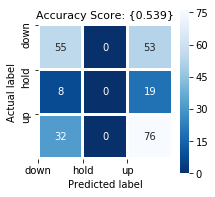

In [513]:
plt.figure(figsize=(3,3))
sns.heatmap(cm, annot=True, fmt="", linewidths=2, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
plt.xticks([0,1,2],['down','hold','up'])
plt.yticks([0,1,2],['down','hold','up'])
all_sample_title = 'Accuracy Score: {%.3f}'%(score)
plt.title(all_sample_title, size = 11);

In [514]:
log_clf.fit (_622_data[x_vars1], _622_data['fu7_label']) # x, y 데이터 순 
score = log_clf.score (_622_data_test[x_vars1], _622_data_test['fu7_label'])

predictions = log_clf.predict(_622_data_test[x_vars1])
cm = metrics.confusion_matrix( _622_data_test['fu7_label'], predictions)

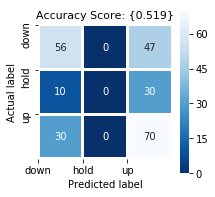

In [515]:
plt.figure(figsize=(3,3))
sns.heatmap(cm, annot=True, fmt="", linewidths=2, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
plt.xticks([0,1,2],['down','hold','up'])
plt.yticks([0,1,2],['down','hold','up'])
all_sample_title = 'Accuracy Score: {%.3f}'%(score)
plt.title(all_sample_title, size = 11);

In [516]:
log_clf.fit (_622_data[x_vars1], _622_data['fu30_label']) # x, y 데이터 순 
score = log_clf.score (_622_data_test[x_vars1], _622_data_test['fu30_label'])

predictions = log_clf.predict(_622_data_test[x_vars1])
cm = metrics.confusion_matrix( _622_data_test['fu30_label'], predictions)

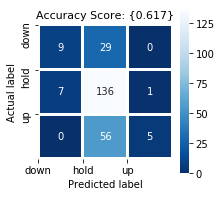

In [517]:
plt.figure(figsize=(3,3))
sns.heatmap(cm, annot=True, fmt="", linewidths=2, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
plt.xticks([0,1,2],['down','hold','up'])
plt.yticks([0,1,2],['down','hold','up'])
all_sample_title = 'Accuracy Score: {%.3f}'%(score)
plt.title(all_sample_title, size = 11);

- 동일한 구간이라고 하더라도 기준 수익률에 따라서 학습의 결과가 달라지기 때문에 정량적으로 비교하는데는 무리가 있다 
- 다만 대체적으로 이러한 접근 방법을 이용해도 false alarm보다는 true alarm의 비율이 조금더 나은것 같다  

## 3) LSTM 모델 적용 
- LSTM 설명 

--- 

- LSTM 관련 사이트를 참고해서 LSTM을 구축함. LSTM을 구현하기 위해서 크게, 데이터를 자르는 부분, 모델 인풋, LSTM 모형 만드는 부분 Loss와 optimizer 부분, 그리고 accuracy를 계산 하는 함수를 만들었음 
- 각종 함수를 활용하여서 네트워크를 구성하고, 학습하는 모델을 만들었음 
- LSTM은 현재를 기준으로 과거의 일부 구간을 확인하여 최종적으로 주가의 라벨(up/down/hold)를 예측하는 것을 목표로 함 

--- 

[실험] 
- LSTM에서 옵션을 변화해가면서 반복 실험(짧게 3회정도) 수행해보면서 실험 결과 비교하기 


----


In [518]:
import tensorflow as tf 

In [680]:
'''
정렬되어 있다고 가정 
stepN = 데이터를 몇개를 볼지 
두 단계가 필요하다 
하나는 배치 하나에 대한 데이터 만들기 
여러 배치로 만들기 
'''
def change_data_for_LSTM(origin_data, batch_size, time_steps, x_label, y_label = 'fu1_label', shuffle = False):
    n_batches_ = len(origin_data) // batch_size 
    if shuffle is True: 
        origin_data = origin_data.sample(frac = 1) 
    temp_x_ = np.array(origin_data[x_label])
    temp_y_ = np.array(origin_data[y_label])   
    x_ = []
    y_ = []
        
    for idx in range(0, len(origin_data)-time_steps):
        x_.append(temp_x_[idx:idx+time_steps])
        y_.append(temp_y_[idx:idx+time_steps])
    
    x_ = x_[:n_batches_ * batch_size]
    y_ = y_[:n_batches_ * batch_size]
   
    
    for ii in range(0, n_batches_):
        yield np.array(x_[ii:ii + batch_size], dtype = np.float32), np.array(y_[ii:ii + batch_size], dtype = np.float32)
        #return np.array(x_[ii:ii + batch_size], dtype = float), np.array(y_[ii:ii + batch_size], dtype = float)

In [ ]:
# test code 
temp_x, temp_y = change_data_for_LSTM(_622_data, 10, 10, x_vars1, 'fu1_label', False)

# for test 
print(temp_x.shape)
print(temp_y.shape)
print(type(temp_x[0][0][0]))
print(temp_x[0][1][:])

- chang_data_for_LSTM은 기존의 데이터를 인풋으로 받아서 batch size를 고려하여 적당한 크기로 자르는 함수 
- time_step(학습에 활용하는 이전 날짜의 정보) 기간 만큼 잘라서 LSTM의 모형에 맞게 변화한다 
    - 즉, 2차원을 3차원의 리스트로 만들어 준다 
- batch size를 고려하여 전체 데이터중 일부만 활용하며, shuffle 옵션에 따라서 셔플을 수행한다 
    - 셔플에 따라서 학습이 안되는 경우도 있을 수 있다 ... (epoch이 증가하면 자연스럽게 문제 해결될 수 있다0 
    - 최대한 모든 데이터를 활용하는 편이 좋을 듯 
- yield 함수는 return과 기능은 동일한데, 요청에 따라서 부분, 부분 리턴해주는 함수라고 한다 
    - 즉, for문을 미리 다 돌아서 리턴을 하는 것이 아니라 요청이 있을 때 마다 한 번씩 도는 것 같다 

In [1011]:
def model_inputs (x_label) : 
    inputs_ = tf.placeholder( tf.float32, [None, None, len(x_label)], name ="inputs" ) # sample, step, input
    
    labels_ = tf.placeholder( tf.float32, [None, None], name ="labels")
    keep_prob_ = tf.placeholder(tf.float32, name = "keep_prob")
    
    return inputs_, labels_, keep_prob_

In [1012]:
'''
lstm_size = 히든레이어 
num_layer = LSTM 쌓아 올리는 
inputs = 데이터 들어온다고 가정  
num_steps = 옆으로 몇 개 mnay to one 
'''
def build_lstm_layers(lstm_sizes, keep_prob_, batch_size, inputs_):
    '''
    def _create_one_cell(): 
        #lstm_cell = tf.contrib.rnn.LSTMCell(lstm_sizes, state_is_tuple=True)
        lstm_cell = tf.contrib.rnn.LSTMCell(lstm_sizes, state_is_tuple=True)
        if keep_prob < 1.0: 
            lstm_cell = tf.contrib.rnn.DropoutWrapper(lstm_cell, output_keep_prob = keep_prob )
        return lstm_cell 
    
      cell = tf.contrib.rnn.MultiRNNCell(
            [_create_one_cell() for _ in range(num_layers)],
            state_is_tuple=True
        ) if num_layers > 1 else _create_one_cell()
    '''
    lstms = [tf.contrib.rnn.BasicLSTMCell(size) for size in lstm_sizes]
    # Add dropout to the cell
    drops = [tf.contrib.rnn.DropoutWrapper(lstm, output_keep_prob=keep_prob_) for lstm in lstms]
    # Stack up multiple LSTM layers, for deep learning
    cell = tf.contrib.rnn.MultiRNNCell(drops)
    
    #inputs_ = tf.transpose(inputs_, [1, 0 , 2])
   

    initial_state = cell.zero_state(batch_size, tf.float32)
     
    lstm_outputs, final_state = tf.nn.dynamic_rnn(cell, inputs_, initial_state=initial_state)

    return initial_state, lstm_outputs, cell, final_state

In [1095]:
def build_cost_fn_and_opt (lstm_outputs, labels_ , learning_rate, time_steps):    
    '''
    predictions = tf.contrib.layers.fully_connected(lstm_outputs[:,-1], 
                                                    1, activation_fn = tf.sigmoid)       
    loss = tf.losses.mean_squared_error(labels_, predictions)
    optimizer = tf.train.AdadeltaOptimizer(learning_rate).minimize(loss)
    '''
    
    predictions = tf.contrib.layers.fully_connected(lstm_outputs[:,-1,:], 
                                                    3, activation_fn = tf.nn.softmax)
    loss = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(logits = lstm_outputs[:,-1,:], 
                                                                         labels = tf.to_int32(labels_[:,-1])))
    optimizer = tf.train.AdadeltaOptimizer(learning_rate).minimize(loss)
    
    
    return predictions, loss, optimizer, labels_
    

In [1087]:
def build_accuracy(predictions, labels_):
    """
    correct_pred = tf.equal(tf.cast(tf.round(predictions), tf.float32), labels_)
    accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))
    """
    correct_pred = tf.equal(tf.cast(tf.argmax(predictions, axis=1), tf.float32), labels_[:,-1])
    accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))
    
    
    
    return accuracy ,labels_ 

In [1106]:
def build_and_train_network(lstm_sizes, epochs, batch_size,
                            learning_rate, keep_prob,time_steps, train_x, val_x, x_label, y_label, shuffle):
    
    inputs_, labels_, keep_prob_ = model_inputs(x_label)
    #embed = tf.cast(np.empty([batch_size, time_steps, len(x_label)]), tf.float32)
    initial_state, lstm_outputs, lstm_cell, final_state = build_lstm_layers(lstm_sizes, keep_prob_,
                                                                            batch_size, inputs_)
    predictions, loss, optimizer, opt_labels_ = build_cost_fn_and_opt(lstm_outputs, labels_, learning_rate , time_steps)
    accuracy, temp_labels = build_accuracy(predictions, labels_)
    
    saver = tf.train.Saver()
    
    with tf.Session() as sess:
        writer = tf.summary.FileWriter("./logs/test")
        writer.add_graph (sess.graph)
        
        sess.run(tf.global_variables_initializer())
        n_batches = len(train_x)//batch_size
        for e in range(epochs):

            state = sess.run(initial_state)
            
            train_acc = []
            
            for ii, (x, y) in enumerate(change_data_for_LSTM(train_x, batch_size, time_steps, x_label, y_label, shuffle), 1):
                                
                feed = {inputs_: x,
                        labels_: y,
                        keep_prob_: keep_prob,
                        initial_state: state}
                loss_, state, _,  batch_acc = sess.run([loss, final_state, optimizer, accuracy], feed_dict=feed)
                train_acc.append(batch_acc)
                
                if (ii + 1) % n_batches == 0:
                    
                    val_acc = []
                    val_state = sess.run(lstm_cell.zero_state(batch_size, tf.float32))
                    for xx, yy in change_data_for_LSTM(val_x, batch_size, time_steps, x_label, y_label, shuffle):
                        feed = {inputs_: xx,
                                labels_: yy,
                                keep_prob_: 1,
                                initial_state: val_state}
                        val_batch_acc, val_state, val_predictions, val_label, temp_l, val_lstmoutput = sess.run([accuracy, final_state, predictions, opt_labels_, temp_labels, lstm_outputs], feed_dict=feed)
                        val_acc.append(val_batch_acc)                       
                    
                    if e % 5 == 0 or e +1 == epochs: 
                        print("Epoch: {}/{}.".format(e+1, epochs),
                              "Batch: {}/{}.".format(ii+1, n_batches),
                              "Train cost: {:.10f}.".format(loss_),
                              "Train Accruacy: {:.3f}.".format(np.mean(train_acc)),
                              "Val Accuracy: {:.3f}".format(np.mean(val_acc)))
    
        saver.save(sess, "checkpoints/sentiment.ckpt")

In [1120]:
# Define Inputs and Hyperparameters

epochs = 20
batch_size = 14
learning_rate = 0.0001
keep_prob = 0.5
time_steps = 30
lstm_sizes = [28, 14]
y_label = 'fu30_label'
shuffle = True
with tf.Graph().as_default():
    build_and_train_network(lstm_sizes, epochs, batch_size,
                            learning_rate, keep_prob, time_steps, _622_data, _622_data_eval, x_vars1, y_label, shuffle)

Epoch: 1/20. Batch: 52/52. Train cost: 2.6614913940. Train Accruacy: 0.381. Val Accuracy: 0.155
Epoch: 6/20. Batch: 52/52. Train cost: 2.6393272877. Train Accruacy: 0.326. Val Accuracy: 0.118
Epoch: 11/20. Batch: 52/52. Train cost: 2.6404502392. Train Accruacy: 0.310. Val Accuracy: 0.202
Epoch: 16/20. Batch: 52/52. Train cost: 2.6434152126. Train Accruacy: 0.357. Val Accuracy: 0.244
Epoch: 20/20. Batch: 52/52. Train cost: 2.6534855366. Train Accruacy: 0.409. Val Accuracy: 0.273


In [1118]:
def test_network(model_dir, batch_size, test_x, time_steps, x_label,y_label, shuffle):
    
    inputs_, labels_, keep_prob_ = model_inputs(x_label)
    #embed = tf.cast(np.empty([batch_size, time_steps, len(x_label)]), tf.float32)
    initial_state, lstm_outputs, lstm_cell, final_state = build_lstm_layers(lstm_sizes, keep_prob_,
                                                                            batch_size, inputs_)
    predictions, loss, optimizer, opt_labels_ = build_cost_fn_and_opt(lstm_outputs, labels_, learning_rate , time_steps)
    accuracy, temp_labels = build_accuracy(predictions, labels_)
    
    
    saver = tf.train.Saver()
    
    test_acc = []
    with tf.Session() as sess:
        saver.restore(sess, tf.train.latest_checkpoint(model_dir))
        test_state = sess.run(lstm_cell.zero_state(batch_size, tf.float32))
        for ii, (x, y) in enumerate(change_data_for_LSTM(test_x, batch_size, time_steps, x_label, y_label, shuffle), 1):
            feed = {inputs_: x,
                    labels_: y,
                    keep_prob_: 1,
                    initial_state: test_state}
            batch_acc, test_state, test_pred, test_label = sess.run([accuracy, final_state, predictions, opt_labels_], feed_dict=feed)
            #if ii == 1: 
                #print(tf.argmax(test_pred,axis=1).eval(), test_label[:,-1])
            test_acc.append(batch_acc)
        print("Test Accuracy: {:.3f}".format(np.mean(test_acc)))
        

In [ ]:
with tf.Graph().as_default():
    test_network('checkpoints', batch_size, _622_data_test, time_steps, x_vars1 ,y_label,  False)

#Test Accuracy: 0.235 - 7 일 학습 - 30일후 예측 
# Test Accuracy: 0.370 - 30일 학습 - 30일후 예측 

---

### 수행한 내역 정리 및 future work 1015
- 회귀 분석 고도화 작업 중 
- volume과 종가를 기준으로 시가 총액을 만들고 해당 일의 실제 종합 지수를 기반으로 현 데이터의 종합 지수 추론 
- 종합 지수를 활용하여 기존의 코드 적용 
- (fw) LSTM 모델 적용 고려 
- 배치 사이즈와 스텝 사이즈에대한 고려가 필요 
- loss, accuracy등 세부적인 조정 필요 
- 일단 코드는 돌아감 

In [678]:
type(_622_data)

pandas.core.frame.DataFrame